In [1]:
!pip install wandb -q

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
# Ignore excessive warnings
#import logging
#logging.propagate = False 
#logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb
import SimpleITK as sitk
from joblib import Parallel, delayed
from functools import partial
from sklearn import metrics
from collections import Counter

In [3]:
wandb.login(key='909ce3174c81bbd40baadacf5a450b33d06199fa')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

In [5]:
def num (image) :
    
    val = 0
    
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

In [6]:
#x for images 
#y for masks
#t for target"label"
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [7]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
    
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  
            if image[0] == 'n' :                           
                X_n[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  
            if image[0] == 'm' :
                X_m[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= np.array(pil_img).reshape(128,128,1)    
            if image[0] == 'n' :                           
                y_n[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  
            if image[0] == 'm' :
                y_m[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  

In [8]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [9]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [10]:
def convertToOneChannel(img):
    im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    i=cv2.resize(im, (128, 128))
    return i

In [11]:
def convertToThreeChannel(img):
    b_np= np.array(img)
    g_np= np.array(img)
    r_np= np.array(img)
    final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
    return np.array(final_img)

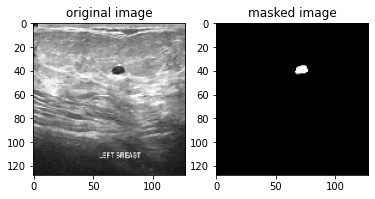

In [12]:
img=convertToThreeChannel(X[0])
mask=convertToThreeChannel(y[0])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

In [13]:
actual=[]
mask=[]

for i in X:
    horizontal_flip = cv2.flip(i, 1)
    vertical_horizontal_flip = cv2.flip(i, -1)
    imagerotate = cv2.rotate(i, cv2.ROTATE_180) 
    imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
    actual.append(horizontal_flip)
    actual.append(vertical_horizontal_flip)
    actual.append(imagerotate)
    actual.append(imagerotate1)
    actual.append(imagerotate2)
    
for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)

In [14]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [15]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

2.0
0.0


In [16]:
mask[mask > 1.0] = 1.0

In [17]:
print(mask.max())
print(mask.min())

1.0
0.0


In [18]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.15, random_state = 1)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10, random_state = 1)

In [21]:
print(X_train.shape)
print(X_test.shape)

(2983, 128, 128)
(585, 128, 128)


In [22]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
    
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[32,64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        
        self.downs = nn.ModuleList()
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        #self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape
if __name__ == "__main__":
    test()

In [23]:
class SegmentationHead(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=None, activation=None, upsampling=1):
        dropout = nn.Dropout(p=dropout, inplace=True) if dropout else nn.Identity()
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        #activation = nn.Sigmoid()
        activation = nn.Identity()
        super().__init__(dropout, conv2d, upsampling, activation)


In [24]:
from typing import Dict, Iterable, Callable
from torch import nn, Tensor

class LayerEnsembles(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))
        self._layer_ensemble_active = False

    def set_output_heads(self, in_channels: Iterable[int], scale_factors: Iterable[int], classes: int, pooling: str = 'avg', dropout: float = None, device ='cpu'):
        if self._layer_ensemble_active:
            raise ValueError("Output heads should be set only once.")
        self._layer_ensemble_active = True
        
        self.output_heads = nn.ModuleList([
            SegmentationHead(
                in_channels=in_channel,
                out_channels=classes,
                kernel_size=3,
                dropout=dropout,
                upsampling=scale_factor,
            ) for in_channel, scale_factor in zip(in_channels, scale_factors)
        ]).to(device)

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        final_layer_output = self.model(x)
        if not self._layer_ensemble_active:
            outputs = {layer: self._features[layer] for layer in self.layers}
        else: 
            outputs = {layer: head(self._features[layer]) for head, layer in zip(self.output_heads, self.layers)}
        outputs['final'] = final_layer_output
        return outputs

In [25]:
architecture = UNET(in_channels=1, out_channels=1)

all_layers = dict([*architecture.named_modules()])
intermediate_layers = []
for name, layer in all_layers.items():
    if '.conv.5' in name:
        intermediate_layers.append(name)

model = LayerEnsembles(architecture, intermediate_layers)
out_channels = []
scale_factors = []
x = torch.randn(32, 1, 128, 128)
output = model(x)
layers = [layer for layer,_  in output.items()]
for key, val in output.items():
    out_channels.append(val.shape[1])
    scale_factors.append(x.shape[-1] // val.shape[-1])
# Set the output heads with the number of channels of the output layers
model.set_output_heads(in_channels=out_channels, scale_factors=scale_factors, classes=1)

In [26]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(X_train,y_train,X_val,y_val,batch_size,num_workers=4,pin_memory=True):
    
    X_train_tensor = torch.Tensor(X_train.reshape(-1,1,128,128))
    y_train_tensor = torch.Tensor(y_train.reshape(-1,1,128,128))
    
    train_loader = DataLoader(TensorDataset(X_train_tensor,y_train_tensor),
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,) 

    X_val_tensor = torch.Tensor(X_val.reshape(-1,1,128,128))
    y_val_tensor = torch.Tensor(y_val.reshape(-1,1,128,128))
    
    val_loader = DataLoader(TensorDataset(X_val_tensor,y_val_tensor),
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,) 

    return train_loader, val_loader    

def get_loaders_test(X_test,y_test):
    
    X_test_tensor = torch.Tensor(X_test.reshape(-1,1,128,128))
    y_test_tensor = torch.Tensor(y_test.reshape(-1,1,128,128))
    
    test_loader = DataLoader(TensorDataset(X_test_tensor,y_test_tensor)) 

    return test_loader   

def check_accuracy(loader, model, loss_fn, epoch, device="cuda", layer='final'):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x)[layer])
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += dice_coef(preds, y)
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    
    print(f"Dice score: {dice_score/len(loader)}")
    if layer == 'final':
        wandb.log({ "val_loss_%s"%layer: loss_fn(preds, y), "val_dice_%s"%layer: dice_score/len(loader)}, step=epoch, commit = True)
    else:
        wandb.log({ "val_loss_%s"%layer: loss_fn(preds, y), "val_dice_%s"%layer: dice_score/len(loader)}, step=epoch, commit = False) 
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y, f"{folder}{idx}.png")

    model.train()
    
def dice_coef(preds,target, treshold=0.5):
    preds = preds>treshold
    target = target>0.5
    intersect = (preds * target).sum()
    union = (preds + target).sum()
    if union == 0:
        return 1.0
    else:
        return (2*intersect/union)

In [27]:
def inference(hyperparameters, model, X, y):

    test_loader = get_loaders_test(X,y)
    load_checkpoint(torch.load("/kaggle/input/breast-cancer-models/model_LE.pth.tar", map_location=hyperparameters['device']), model)
    device=hyperparameters['device']
    tests = []
    tests_pred = []
    tests_pred_bin = []
    x_tests = []
    count_test = 0
    total_dice = 0
    
    model.eval()
    for idx, (x, y) in enumerate(test_loader):
        dice_score = 0
        x = x.to(device=device)
        y = y.to(device=device)
        with torch.no_grad():
            outputs_tests = model(x)
            test_preds = [torch.sigmoid(out) for _, out in outputs_tests.items()]
            test_preds_bin = [(torch.sigmoid(out)> 0.5).float() for _, out in outputs_tests.items()]
        tests.append(y)
        tests_pred.append(test_preds)
        tests_pred_bin.append(test_preds_bin)
        x_tests.append(x)
        dice_score += dice_coef(test_preds_bin[-1], y)
        total_dice += dice_score
        #wandb.log({"dice_per_test": dice_score}, step=count_test)
        count_test +=1
        
    return x_tests, tests, tests_pred, tests_pred_bin

In [28]:
# Hyperparameters etc.
DEVICE = "cpu"
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 128  
IMAGE_WIDTH = 128  
PIN_MEMORY = True
LOAD_MODEL = False
n_ensembles = 1
hyperparameters= dict(epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, num_workers=NUM_WORKERS, device=DEVICE, pin_memory=PIN_MEMORY, load_model=LOAD_MODEL )


x_tests, tests, tests_pred, tests_pred_bin = inference(hyperparameters, model, X_test,y_test)

=> Loading checkpoint


In [29]:
x_vals, vals, vals_pred, vals_pred_bin = inference(hyperparameters, model, X_val,y_val)

=> Loading checkpoint


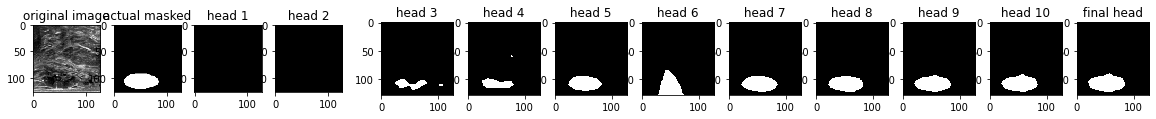

In [30]:
index = 4
img= x_tests[index].cpu().numpy().reshape(128,128)
mask = tests[index].cpu().numpy().reshape(128,128)
predict_1 = tests_pred_bin[index][0].cpu().numpy().reshape(128,128)
predict_2 = tests_pred_bin[index][1].cpu().numpy().reshape(128,128)
predict_3 = tests_pred_bin[index][2].cpu().numpy().reshape(128,128)
predict_4 = tests_pred_bin[index][3].cpu().numpy().reshape(128,128)
predict_5 = tests_pred_bin[index][4].cpu().numpy().reshape(128,128)
predict_6 = tests_pred_bin[index][5].cpu().numpy().reshape(128,128)
predict_7 = tests_pred_bin[index][6].cpu().numpy().reshape(128,128)
predict_8 = tests_pred_bin[index][7].cpu().numpy().reshape(128,128)
predict_9 = tests_pred_bin[index][8].cpu().numpy().reshape(128,128)
predict_10 = tests_pred_bin[index][9].cpu().numpy().reshape(128,128)
predict_11 = tests_pred_bin[index][10].cpu().numpy().reshape(128,128)
predict_11 = tests_pred_bin[index][11].cpu().numpy().reshape(128,128)

plt.figure(figsize=(20,10))
plt.subplot(1,14,1)
plt.imshow(img,interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,14,2)
plt.imshow(mask,interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,14,3)
plt.imshow(predict_1,interpolation='nearest',cmap='gray')
plt.title(" head 1 ")
plt.subplot(1,14,4)
plt.imshow(predict_2,interpolation='nearest',cmap='gray')
plt.title(" head 2 ")
plt.subplot(1,13,5)
plt.imshow(predict_3,interpolation='nearest',cmap='gray')
plt.title(" head 3 ")
plt.subplot(1,13,6)
plt.imshow(predict_4,interpolation='nearest',cmap='gray')
plt.title(" head 4 ")
plt.subplot(1,13,7)
plt.imshow(predict_5,interpolation='nearest',cmap='gray')
plt.title(" head 5 ")
plt.subplot(1,13,8)
plt.imshow(predict_6,interpolation='nearest',cmap='gray')
plt.title(" head 6 ")
plt.subplot(1,13,9)
plt.imshow(predict_7,interpolation='nearest',cmap='gray')
plt.title(" head 7 ")
plt.subplot(1,13,10)
plt.imshow(predict_8,interpolation='nearest',cmap='gray')
plt.title(" head 8 ")
plt.subplot(1,13,11)
plt.imshow(predict_9,interpolation='nearest',cmap='gray')
plt.title(" head 9 ")
plt.subplot(1,13,12)
plt.imshow(predict_10,interpolation='nearest',cmap='gray')
plt.title(" head 10 ")
plt.subplot(1,13,13)
plt.imshow(predict_11,interpolation='nearest',cmap='gray')
plt.title(" final head ")
plt.show()

In [31]:
#função para calcular o parametro r para a dice norm
def r_calc(gt):
    
    return np.sum(gt) /len(gt.flatten())

r_list = [r_calc(i) for i in y_train]
r = np.mean(r_list, axis=0)
print(r)

0.07830069136604054


In [32]:
#função dice norm
def dice_norm_metric(predictions, ground_truth, r = r, threshold = 0.5):
    """
    Compute Normalised Dice Coefficient (nDSC), 
    False positive rate (FPR),
    False negative rate (FNR) for a single example.
    
    Args:
      ground_truth: `numpy.ndarray`, binary ground truth segmentation target,
                     with shape [H, W, D].
      predictions:  `numpy.ndarray`, binary segmentation predictions,
                     with shape [H, W, D].
    Returns:
      Normalised dice coefficient (`float` in [0.0, 1.0]),
      False positive rate (`float` in [0.0, 1.0]),
      False negative rate (`float` in [0.0, 1.0]),
      between `ground_truth` and `predictions`.
    """

    # Cast to float32 type
    gt = ground_truth>threshold
    gt = gt.astype("float32")
    seg = predictions>threshold
    seg = seg.astype("float32")
    
    im_sum = np.sum(seg) + np.sum(gt)
    if im_sum == 0:
        return 1.0
    else:
        if np.sum(gt) == 0:
            k = 1.0
        else:
            k = (1 - r) * np.sum(gt) / (r * (len(gt.flatten()) - np.sum(gt)))
        tp = np.sum(seg[gt == 1])
        fp = np.sum(seg[gt == 0])
        fn = np.sum(gt[seg == 0])
        fp_scaled = k * fp
        dsc_norm = 2. * tp / (fp_scaled + 2. * tp + fn)
        return dsc_norm

In [33]:
def soft_dice_norm_metric(pred, target, r=0.0783):
    """
    Compute Normalised Dice Coefficient (nDSC), 
    False positive rate (FPR),
    False negative rate (FNR) for a single example.
    
    Args:
      target: `numpy.ndarray`, binary ground truth segmentation target,
                     with shape [H, W, D].
      pred:  `numpy.ndarray`, binary segmentation predictions,
                     with shape [H, W, D].
    Returns:
      Normalised dice coefficient (`float` in [0.0, 1.0]),
      False positive rate (`float` in [0.0, 1.0]),
      False negative rate (`float` in [0.0, 1.0]),
      between `ground_truth` and `predictions`.
    """
    smooth = 1.

    # Cast to float32 type
    gt = target.astype("float32")
    seg = pred.astype("float32")

    im_sum = np.sum(seg) + np.sum(gt)
    if im_sum == 0:
        return 1.0
    else:
        if np.sum(gt) == 0:
            k = 1.0
        else:
            k = (1 - r) * np.sum(gt) / (r * (len(gt.flatten()) - np.sum(gt)))
        tp = np.sum(seg * gt)
        fp = np.sum(seg * (1 - gt))
        fn = np.sum((1 - seg) * gt)
        fp_scaled = k * fp
        dsc_norm = (2. * tp + smooth) / (fp_scaled + 2. * tp + fn + smooth)

        return dsc_norm

In [34]:
#função para criar o STAMPLE entre as cabeças selecionadas
def STAPLE_func(pred_bin):
    total_STAPLES = {number_head:[] for number_head in range(len(pred_bin[0]))}
    for key in total_STAPLES.keys():
        for j in range(len(pred_bin)):
            segs = [pred_bin[j][i].cpu().numpy().reshape(128,128) for i in range(len(pred_bin[0])-1,key-1,-1)]

            seg_stack = [sitk.GetImageFromArray(seg.astype(np.int16)) for seg in segs]

            # Run STAPLE algorithm
            STAPLE_seg_sitk = sitk.STAPLE(seg_stack, 1.0 ) # 1.0 specifies the foreground value

            # convert back to numpy array
            STAPLE_seg = sitk.GetArrayFromImage(STAPLE_seg_sitk)
            total_STAPLES[key].append(STAPLE_seg)
    return total_STAPLES
        

In [35]:
#função para carcular a média das saídas da última cabeça até a selecionada
def average_head_func(pred):
    total_mean = {number_head:[] for number_head in range(len(pred[0]))}
    for key in total_mean.keys():
        for j in range(len(pred)):
            choosen_heads = [pred[j][i].cpu().numpy().reshape(128,128) for i in range(len(pred[0])-1,key-1,-1)]
            total_mean[key].append(np.mean(choosen_heads, axis =0))
    return total_mean

In [36]:
#Exemplo de STAPLE

# STAPLE is availabe as a SITK package. To use, convert segmentations to SITK image objects
segs = [tests_pred_bin[index][i].cpu().numpy().reshape(128,128) for i in range(len(tests_pred_bin[index]))]

seg_stack = [sitk.GetImageFromArray(seg.astype(np.int16)) for seg in segs]

# Run STAPLE algorithm
STAPLE_seg_sitk = sitk.STAPLE(seg_stack, 1.0 ) # 1.0 specifies the foreground value

# convert back to numpy array
STAPLE_seg = sitk.GetArrayFromImage(STAPLE_seg_sitk)

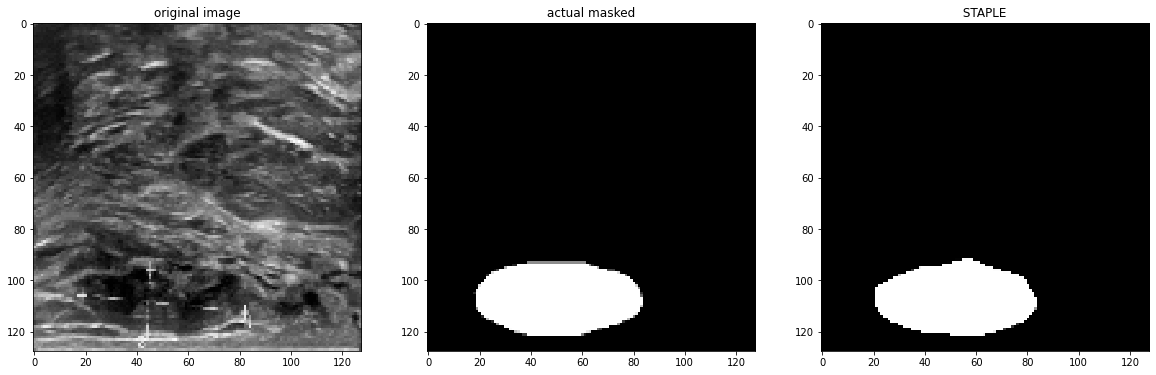

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img,interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask,interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(STAPLE_seg,interpolation='nearest',cmap='gray')
plt.title(" STAPLE ")
plt.show()

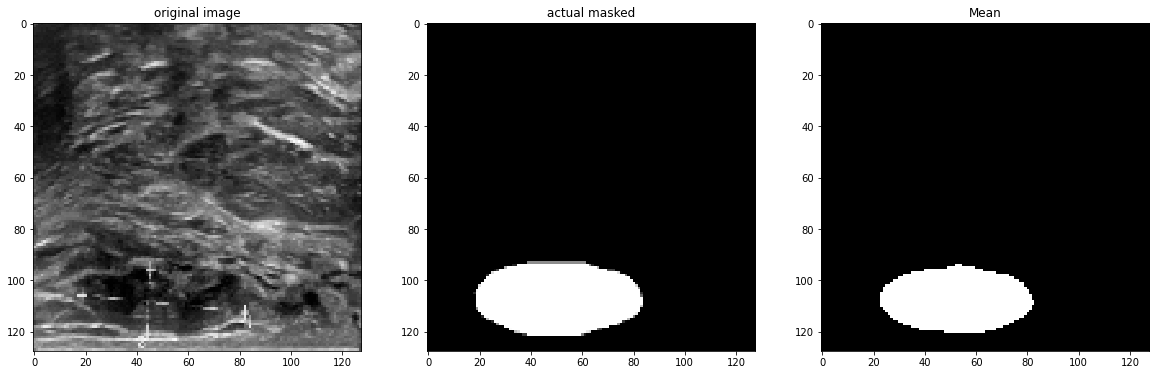

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img,interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask,interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(average_head_func(tests_pred)[0][index]>0.5,interpolation='nearest',cmap='gray')
plt.title("Mean")
plt.show()


In [39]:
#função para calcular as AULAS a partir da ultima até a cabeça selecionada
def aula_head_func(pred):
    aula_heads = {number_head:[] for number_head in range(len(pred[0])-1)}
    for key in aula_heads.keys():
        for j in range(len(pred)):
            aula_curve = [dice_coef(pred[j][i-1].cpu().numpy().reshape(128,128),pred[j][i].cpu().numpy().reshape(128,128)) for i in range(len(pred[0])-1,key,-1)]
            if len(pred[0])-2 > key:
                aula_heads[key].append(np.trapz(aula_curve , dx=1))
            else:
                aula_heads[key].append(aula_curve[0])
        aula_heads[key] = np.array(aula_heads[key])
    return aula_heads

In [40]:
#função para calcular as AULAS com dice norm a partir da ultima até a cabeça selecionada
def aula_ndsc_head_func(pred):
    aula_heads = {number_head:[] for number_head in range(len(pred[0])-1)}
    for key in aula_heads.keys():
        for j in range(len(pred)):
            aula_curve = [dice_norm_metric(pred[j][i-1].cpu().numpy().reshape(128,128),pred[j][i].cpu().numpy().reshape(128,128)) for i in range(len(pred[0])-1,key,-1)]
            if len(pred[0])-2 > key:
                aula_heads[key].append(np.trapz(aula_curve , dx=1))
            else:
                aula_heads[key].append(aula_curve[0])
        aula_heads[key] = np.array(aula_heads[key])
    return aula_heads

In [41]:
#função para realizar a curva de retenção
def compute_retention_curve(confidence: np.ndarray, dices: np.ndarray):
    ordering = confidence.argsort()

    scores_ = confidence[ordering]
    dices_ = dices[ordering]

    retention_percentage = list()
    retention_score = list()
    for i in range(len(scores_) + 1):
        retention_percentage.append(i / len(scores_))
        ret_dices_ = np.ones_like(dices_)
        ret_dices_[:i] = dices_[:i]
        retention_score.append(np.mean(ret_dices_))

    return retention_percentage, retention_score



In [42]:
val_pred_means = average_head_func(vals_pred) #dicionário com a média das cabeças selecionadas na validação

In [43]:
val_ndice_mean = [] #médias da norm dices na validação
for key in val_pred_means:
    val_ndice = [dice_norm_metric(val_pred_means[key][i],v.cpu().numpy().reshape(128,128)) for i,v in enumerate(vals)]
    val_ndice_mean.append(np.mean(val_ndice))

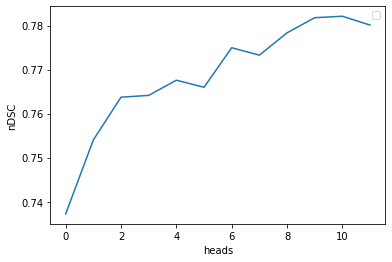

In [44]:
#gráfico com a dice norm maior de acordo com as cabeças selecionadas
plt.plot(np.arange(len(val_ndice_mean)), np.asarray(val_ndice_mean))
plt.xlabel("heads")
plt.ylabel("nDSC")
plt.legend()
plt.show()

In [45]:
np.argmax(val_ndice_mean) #ultima cabeça a ser selecionada a partir da ultima

10

In [46]:
heads = np.argmax(val_ndice_mean) #ultima cabeça a ser selecionada a partir da ultima

In [47]:
#incertezas calculadas a ser selecionada a partir da ultima até a apontada
def uncertainties_heads(preds,heads):
    uncertainty_cat = []
    for i in range(len(preds[0])-1,heads-1,-1):
        choosen_heads = [pred[i].cpu().numpy().reshape(128,128,1) for pred in preds]
        uncertainty_cat.append(choosen_heads)
        
    uncertainty_cat = np.array(uncertainty_cat,dtype='float32')
    
    return np.concatenate((uncertainty_cat, 1-uncertainty_cat), axis = -1)

In [48]:
#incertezas da ultima cabeça
def uncertainties_final_heads(preds):
    uncertainty_cat =[pred[-1].cpu().numpy().reshape(128,128,1) for pred in preds]
    uncertainty_cat = np.array([uncertainty_cat],dtype='float32')
    
    return np.concatenate((uncertainty_cat, 1-uncertainty_cat), axis = -1)

In [49]:
vals_uncert_heads = uncertainties_heads(vals_pred,heads) #incertezas da validação selecionada até a cabeça heads

In [50]:
vals_uncert_final_head = uncertainties_final_heads(vals_pred) #incertezas da validação da última cabeça

In [51]:
#funções de medidas de incertezas
def entropy_of_expected(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_classes]
    :return: array [num_voxels_X, num_voxels_Y]
    """
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=-1)

def expected_entropy(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    log_probs = -np.log(probs + epsilon)
    return np.mean(np.sum(probs * log_probs, axis=-1), axis=0)


def ensemble_uncertainties_classification(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: Dictionary of uncertainties
    """
    mean_probs = np.mean(probs, axis=0)
    mean_lprobs = np.mean(np.log(probs + epsilon), axis=0)
    conf = np.max(mean_probs, axis=-1)

    eoe = entropy_of_expected(probs, epsilon)
    exe = expected_entropy(probs, epsilon)

    mutual_info = eoe - exe

    epkl = -np.sum(mean_probs * mean_lprobs, axis=-1) - exe

    uncertainty = {'confidence': conf,
                   'entropy_of_expected': eoe,
                   'expected_entropy': exe,
                   'mutual_information': mutual_info,
                   'epkl': epkl,
                   'reverse_mutual_information': epkl - mutual_info,
                   }

    return uncertainty

In [52]:
#calculo das norm_dices na validação
norm_dices_val = list()
for ind, p in enumerate(val_pred_means[heads]):
    norm_dices_val.append(dice_norm_metric(p, vals[ind].cpu().numpy().reshape(128,128)))
norm_dices_val = np.asarray(norm_dices_val)

In [53]:
aula_ndsc_val = aula_ndsc_head_func(vals_pred) #AULAS das cabeças na validação


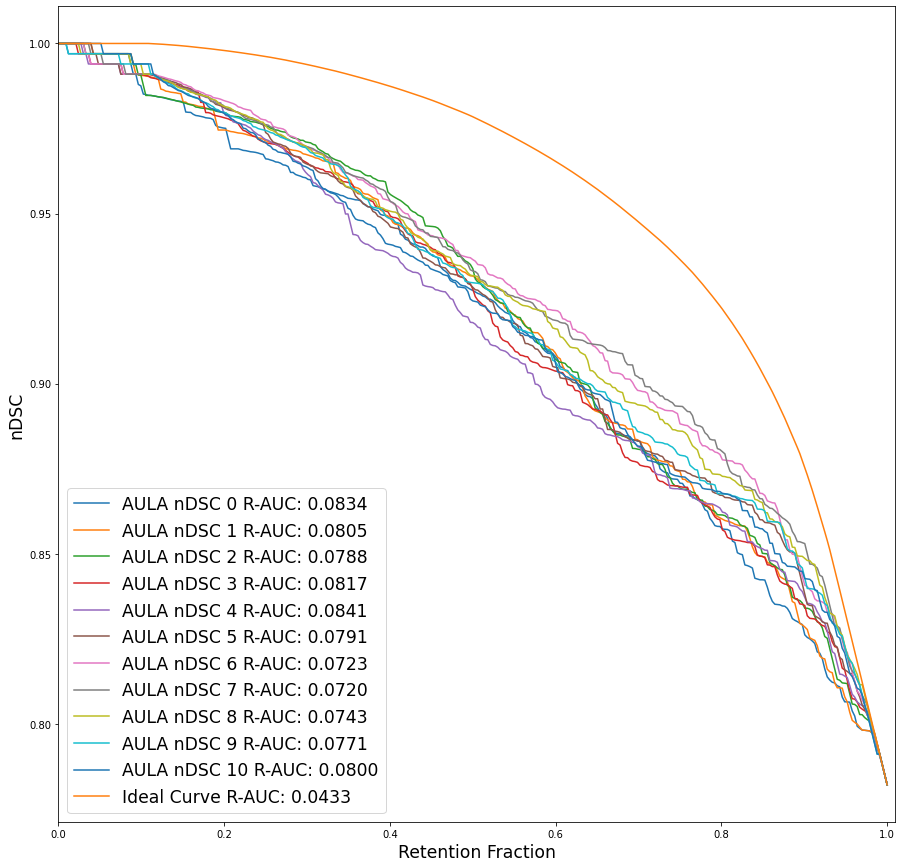

In [54]:
xn = dict()
yn = dict()

for key in aula_ndsc_val.keys():
    xn[key], yn[key] = compute_retention_curve(-1*aula_ndsc_val[key], norm_dices_val)

xi, yi = compute_retention_curve(-1*norm_dices_val, norm_dices_val)

plt.figure(figsize=(15,15))
for key in aula_ndsc_val.keys():
    plt.plot(xn[key], yn[key], label=f"AULA nDSC %d R-AUC: {1. - metrics.auc(xn[key], yn[key]):.4f}"%key)

plt.plot(xi, yi, label=f"Ideal Curve R-AUC: {1. - metrics.auc(xi, yi):.4f}")
plt.xlabel("Retention Fraction", fontsize = 'xx-large')
plt.ylabel("nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.show()

In [55]:
vals_uncert_aula_heads = uncertainties_heads(vals_pred,7)

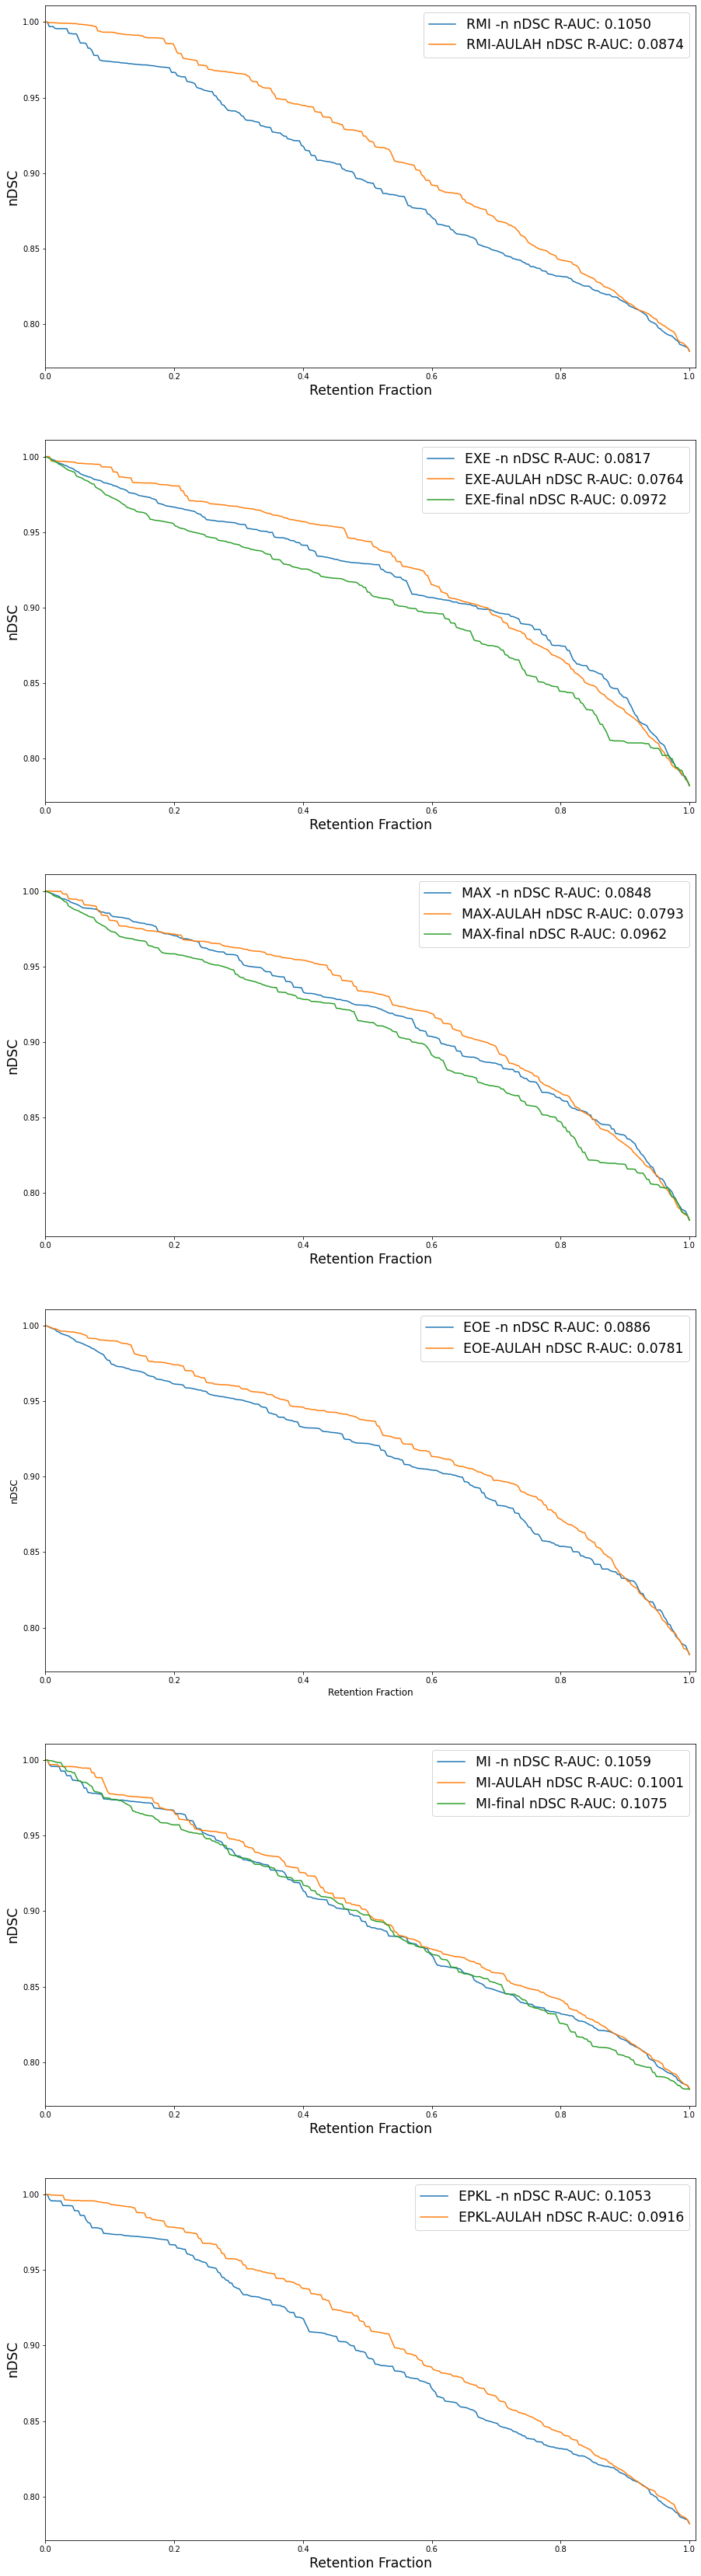

In [56]:
rmi_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_heads[:,:,:,:,:])['reverse_mutual_information'], axis=(1,2))
exe_head = np.mean(ensemble_uncertainties_classification(vals_uncert_heads[:,:,:,:,:])['expected_entropy'], axis=(1,2))
confidences_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_heads[:,:,:,:,:])['confidence'], axis=(1,2))
eoe_head = np.mean(ensemble_uncertainties_classification(vals_uncert_heads[:,:,:,:,:])['entropy_of_expected'], axis=(1,2))
mi_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_heads[:,:,:,:,:])['mutual_information'], axis=(1,2))
epkl_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_heads[:,:,:,:,:])['epkl'], axis=(1,2))

exe_final_head = np.mean(ensemble_uncertainties_classification(vals_uncert_final_head[:,:,:,:,:])['expected_entropy'], axis=(1,2))
confidences_final_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_final_head[:,:,:,:,:])['confidence'], axis=(1,2))
mi_final_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_final_head[:,:,:,:,:])['mutual_information'], axis=(1,2))

rmi_aula_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_aula_heads[:,:,:,:,:])['reverse_mutual_information'], axis=(1,2))
exe_aula_head = np.mean(ensemble_uncertainties_classification(vals_uncert_aula_heads[:,:,:,:,:])['expected_entropy'], axis=(1,2))
confidences_aula_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_aula_heads[:,:,:,:,:])['confidence'], axis=(1,2))
eoe_aula_head = np.mean(ensemble_uncertainties_classification(vals_uncert_aula_heads[:,:,:,:,:])['entropy_of_expected'], axis=(1,2))
mi_aula_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_aula_heads[:,:,:,:,:])['mutual_information'], axis=(1,2))
epkl_aula_head = np.mean(-1*ensemble_uncertainties_classification(vals_uncert_aula_heads[:,:,:,:,:])['epkl'], axis=(1,2))



x1, y1 = compute_retention_curve(rmi_head , norm_dices_val)

x2, y2 = compute_retention_curve(exe_head, norm_dices_val)

x3, y3 = compute_retention_curve(confidences_head, norm_dices_val)

x4, y4 = compute_retention_curve(eoe_head, norm_dices_val)

x5, y5 = compute_retention_curve(mi_head, norm_dices_val)

x6, y6 = compute_retention_curve(epkl_head, norm_dices_val)

x7, y7 = compute_retention_curve(rmi_aula_head, norm_dices_val)

x8, y8 = compute_retention_curve(exe_aula_head, norm_dices_val)

x9, y9 = compute_retention_curve(confidences_aula_head, norm_dices_val)

x10,y10 = compute_retention_curve(eoe_aula_head, norm_dices_val)

x11,y11 = compute_retention_curve(mi_aula_head, norm_dices_val)

x12,y12 = compute_retention_curve(epkl_aula_head, norm_dices_val)

x13,y13 = compute_retention_curve(exe_final_head, norm_dices_val)

x14,y14 = compute_retention_curve(confidences_final_head, norm_dices_val)

x15,y15 = compute_retention_curve(mi_final_head, norm_dices_val)

plt.figure(figsize=(15,60))
plt.subplot(6,1,1)
plt.plot(x1, y1, label=f"RMI -n nDSC R-AUC: {1. - metrics.auc(x1, y1):.4f}")
plt.plot(x7, y7, label=f"RMI-AULAH nDSC R-AUC: {1. - metrics.auc(x7, y7):.4f}")
plt.xlabel("Retention Fraction", fontsize = 'xx-large')
plt.ylabel("nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.subplot(6,1,2)
plt.plot(x2, y2, label=f"EXE -n nDSC R-AUC: {1. - metrics.auc(x2, y2):.4f}")
plt.plot(x8, y8, label=f"EXE-AULAH nDSC R-AUC: {1. - metrics.auc(x8, y8):.4f}")
plt.plot(x13, y13, label=f"EXE-final nDSC R-AUC: {1. - metrics.auc(x13, y13):.4f}")
plt.xlabel("Retention Fraction", fontsize = 'xx-large')
plt.ylabel("nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.subplot(6,1,3)
plt.plot(x3, y3, label=f"MAX -n nDSC R-AUC: {1. - metrics.auc(x3, y3):.4f}")
plt.plot(x9, y9, label=f"MAX-AULAH nDSC R-AUC: {1. - metrics.auc(x9, y9):.4f}")
plt.plot(x14, y14, label=f"MAX-final nDSC R-AUC: {1. - metrics.auc(x14, y14):.4f}")
plt.xlabel("Retention Fraction", fontsize = 'xx-large')
plt.ylabel("nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.subplot(6,1,4)
plt.plot(x4, y4, label=f"EOE -n nDSC R-AUC: {1. - metrics.auc(x4, y4):.4f}")
plt.plot(x10, y10, label=f"EOE-AULAH nDSC R-AUC: {1. - metrics.auc(x10, y10):.4f}")
plt.xlabel("Retention Fraction", fontsize = 'large')
plt.ylabel("nDSC", fontsize = 'large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.subplot(6,1,5)
plt.plot(x5, y5, label=f"MI -n nDSC R-AUC: {1. - metrics.auc(x5, y5):.4f}")
plt.plot(x11, y11, label=f"MI-AULAH nDSC R-AUC: {1. - metrics.auc(x11, y11):.4f}")
plt.plot(x15, y15, label=f"MI-final nDSC R-AUC: {1. - metrics.auc(x15, y15):.4f}")
plt.xlabel("Retention Fraction", fontsize = 'xx-large')
plt.ylabel("nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.subplot(6,1,6)
plt.plot(x6, y6, label=f"EPKL -n nDSC R-AUC: {1. - metrics.auc(x6, y6):.4f}")
plt.plot(x12, y12, label=f"EPKL-AULAH nDSC R-AUC: {1. - metrics.auc(x12, y12):.4f}")
plt.xlabel("Retention Fraction", fontsize = 'xx-large')
plt.ylabel("nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.show()



In [57]:
def aula_ndsc_heads_mean_func(pred,pred_mean):
    aula_heads = {number_head:[] for number_head in range(len(pred[0])-1)}
    for key in aula_heads.keys():
        for j in range(len(pred)):
            aula_curve = [dice_norm_metric(pred[j][i].cpu().numpy().reshape(128,128),pred_mean[j]) for i in range(len(pred[0])-1,key,-1)]
            aula_heads[key].append(np.mean(aula_curve))
        aula_heads[key] = np.array(aula_heads[key])
    return aula_heads

In [58]:
def aula_ndsc_final_heads_mean(pred,pred_mean):
    aula_heads = []
    for j in range(len(pred)):
        aula_heads.append(dice_norm_metric(pred[j][-1].cpu().numpy().reshape(128,128),pred_mean[j]))
    aula_heads = np.array(aula_heads)
    return aula_heads

In [59]:
aula_ndsc_final_heads_val = aula_ndsc_final_heads_mean(vals_pred,val_pred_means[heads])

In [60]:
aula_ndsc_val = aula_ndsc_heads_mean_func(vals_pred,val_pred_means[heads])

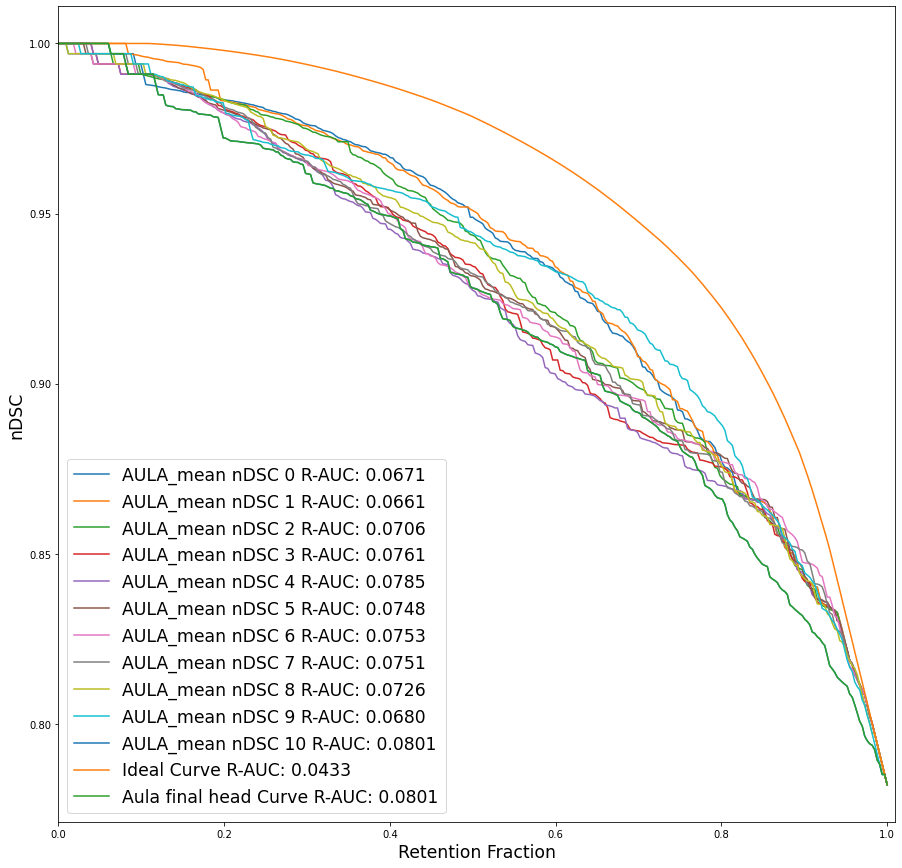

In [61]:
xn = dict()
yn = dict()

for key in aula_ndsc_val.keys():
    xn[key], yn[key] = compute_retention_curve(-1*aula_ndsc_val[key], norm_dices_val)

xf, yf = compute_retention_curve(-1*aula_ndsc_final_heads_val, norm_dices_val)
xi, yi = compute_retention_curve(-1*norm_dices_val, norm_dices_val)

plt.figure(figsize=(15,15))
for key in aula_ndsc_val.keys():
    plt.plot(xn[key], yn[key], label=f"AULA_mean nDSC %d R-AUC: {1. - metrics.auc(xn[key], yn[key]):.4f}"%key)


plt.plot(xi, yi, label=f"Ideal Curve R-AUC: {1. - metrics.auc(xi, yi):.4f}")    
plt.plot(xf, yf, label=f"Aula final head Curve R-AUC: {1. - metrics.auc(xf, yf):.4f}")
plt.xlabel("Retention Fraction", fontsize = 'xx-large')
plt.ylabel("nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.show()

In [62]:
def aula_ndsc_corresp_heads_mean_func(pred,pred_mean):
    aula_heads = {number_head:[] for number_head in range(len(pred[0])-1)}
    for key in aula_heads.keys():
        for j in range(len(pred)):
            aula_curve = [dice_norm_metric(pred[j][i].cpu().numpy().reshape(128,128),pred_mean[key][j]) for i in range(len(pred[0])-1,key,-1)]
            aula_heads[key].append(np.mean(aula_curve))
        aula_heads[key] = np.array(aula_heads[key])
    return aula_heads

In [63]:
aula_corresp_ndsc_val = aula_ndsc_corresp_heads_mean_func(vals_pred,val_pred_means)

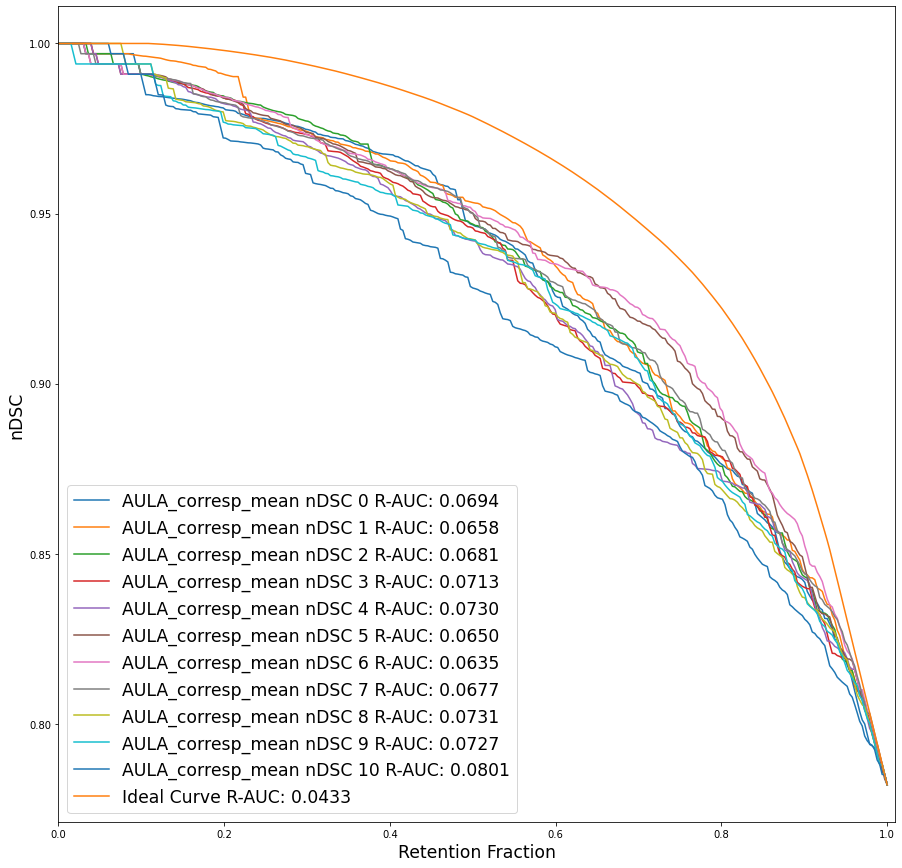

In [64]:
xn = dict()
yn = dict()

for key in aula_corresp_ndsc_val.keys():
    xn[key], yn[key] = compute_retention_curve(-1*aula_corresp_ndsc_val[key], norm_dices_val)

xf, yf = compute_retention_curve(-1*aula_ndsc_final_heads_val, norm_dices_val)
xi, yi = compute_retention_curve(-1*norm_dices_val, norm_dices_val)

plt.figure(figsize=(15,15))
for key in aula_corresp_ndsc_val.keys():
    plt.plot(xn[key], yn[key], label=f"AULA_corresp_mean nDSC %d R-AUC: {1. - metrics.auc(xn[key], yn[key]):.4f}"%key)


plt.plot(xi, yi, label=f"Ideal Curve R-AUC: {1. - metrics.auc(xi, yi):.4f}")    
plt.xlabel("Retention Fraction", fontsize = 'xx-large')
plt.ylabel("nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.show()

In [65]:
def dice_loss(y_pred, y_true):
    intersection = np.sum(y_true * y_pred)
    sum_of_squares_pred = np.sum(np.square(y_pred))
    sum_of_squares_true = np.sum(np.square(y_true))
    if sum_of_squares_pred == sum_of_squares_true and sum_of_squares_pred == 0:
        dice = 1
    else:
        dice = 1 - (2 * intersection) / (sum_of_squares_pred + sum_of_squares_true)
    return dice

In [66]:
def var_score(y, y_mean):
    n = y_mean.size
    return np.sum(np.square(y-y_mean))/(n-1)

In [67]:
def aula_dice_loss_mean_func(pred,pred_mean):
    aula_heads = {number_head:[] for number_head in range(len(pred[0])-1)}
    for key in aula_heads.keys():
        for j in range(len(pred)):
            aula_curve = [dice_loss(pred[j][i].cpu().numpy().reshape(128,128),pred_mean[j]) for i in range(len(pred[0])-1,key,-1)]
            aula_heads[key].append(np.mean(aula_curve))
        aula_heads[key] = np.array(aula_heads[key])
    return aula_heads

In [68]:
def aula_nsoft_dice_mean_func(pred,pred_mean):
    aula_heads = {number_head:[] for number_head in range(len(pred[0])-1)}
    for key in aula_heads.keys():
        for j in range(len(pred)):
            aula_curve = [soft_dice_norm_metric(pred[j][i].cpu().numpy().reshape(128,128),pred_mean[j]) for i in range(len(pred[0])-1,key,-1)]
            aula_heads[key].append(np.mean(aula_curve))
        aula_heads[key] = np.array(aula_heads[key])
    return aula_heads

In [69]:
def compute_var_func(pred,pred_mean):
    var = {number_head:[] for number_head in range(len(pred[0])-1)}
    for key in var.keys():
        for j in range(len(pred)):
            pred_var = np.array([pred[j][i].cpu().numpy().reshape(128,128) for i in range(len(pred[0])-1,key,-1)])
            var[key].append(var_score(pred_var,pred_mean[key][j]))
        var[key] = np.array(var[key])
    return var

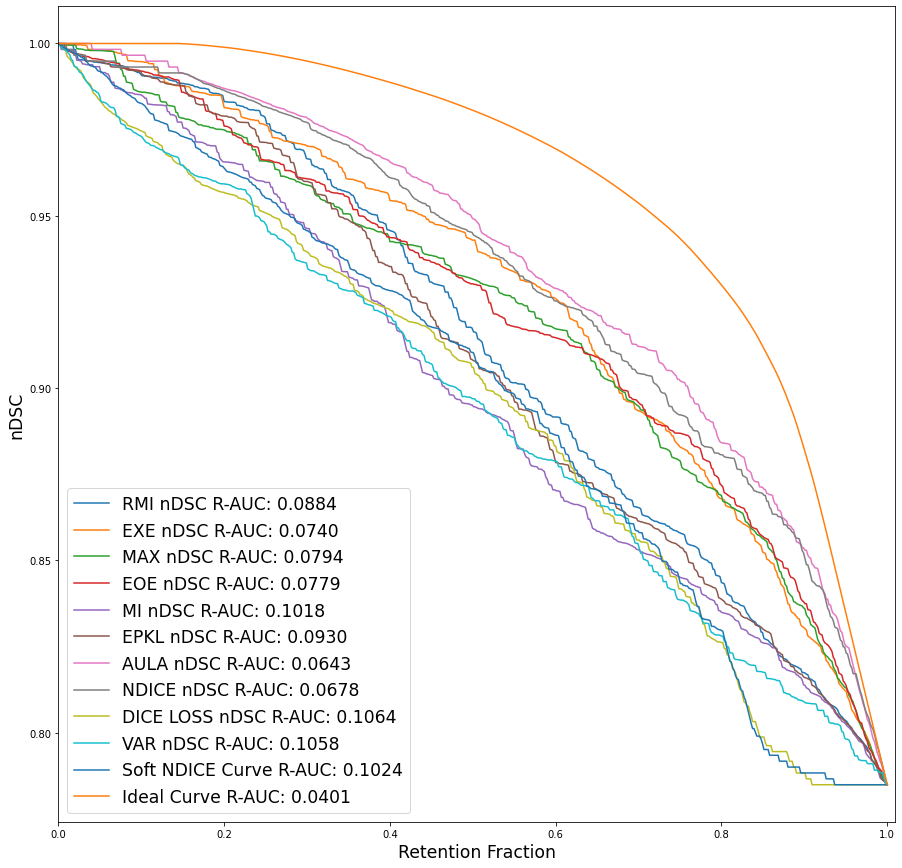

In [70]:
aula_ndsc_test = aula_ndsc_head_func(tests_pred)[7]
tests_uncert_aula_head = uncertainties_heads(tests_pred,7)
test_pred_means = average_head_func(tests_pred)
aula_mean_ndsc_test = aula_ndsc_heads_mean_func(tests_pred,test_pred_means[heads])[7]

norm_dices_test = list()
for ind, p in enumerate(test_pred_means[heads]):
    norm_dices_test.append(dice_norm_metric(p,tests[ind].cpu().numpy().reshape(128,128)))
norm_dices_test = np.asarray(norm_dices_test)

rmi = np.mean(-1*ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['reverse_mutual_information'], axis=(1,2))
exe = np.mean(ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['expected_entropy'], axis=(1,2))
confidences = np.mean(-1*ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['confidence'], axis=(1,2))
eoe = np.mean(ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['entropy_of_expected'], axis=(1,2))
mi = np.mean(-1*ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['mutual_information'], axis=(1,2))
epkl = np.mean(-1*ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['epkl'], axis=(1,2))
aula_dice_loss_mean = aula_dice_loss_mean_func(tests_pred,test_pred_means[heads])[7]
var_uncert = compute_var_func(tests_pred,test_pred_means)[7]
aula_mean_nsoft_dice_test = aula_nsoft_dice_mean_func(tests_pred,test_pred_means[heads])[7]

x1, y1 = compute_retention_curve(rmi, norm_dices_test)

x2, y2 = compute_retention_curve(exe, norm_dices_test)

x3, y3 = compute_retention_curve(confidences, norm_dices_test)

x4, y4 = compute_retention_curve(eoe, norm_dices_test)

x5, y5 = compute_retention_curve(mi, norm_dices_test)

x6, y6 = compute_retention_curve(epkl, norm_dices_test)

x7, y7 = compute_retention_curve(-1*aula_ndsc_test, norm_dices_test)

x8, y8 = compute_retention_curve(-1*aula_mean_ndsc_test, norm_dices_test)

x9, y9 = compute_retention_curve(aula_dice_loss_mean, norm_dices_test)

x10, y10 = compute_retention_curve(var_uncert, norm_dices_test)

x11, y11 = compute_retention_curve(-1*aula_mean_nsoft_dice_test, norm_dices_test)

x12, y12 = compute_retention_curve(-1*norm_dices_test, norm_dices_test)

plt.figure(figsize=(15,15))
plt.plot(x1, y1, label=f"RMI nDSC R-AUC: {1. - metrics.auc(x1, y1):.4f}")
plt.plot(x2, y2, label=f"EXE nDSC R-AUC: {1. - metrics.auc(x2, y2):.4f}")
plt.plot(x3, y3, label=f"MAX nDSC R-AUC: {1. - metrics.auc(x3, y3):.4f}")
plt.plot(x4, y4, label=f"EOE nDSC R-AUC: {1. - metrics.auc(x4, y4):.4f}")
plt.plot(x5, y5, label=f"MI nDSC R-AUC: {1. - metrics.auc(x5, y5):.4f}")
plt.plot(x6, y6, label=f"EPKL nDSC R-AUC: {1. - metrics.auc(x6, y6):.4f}")
plt.plot(x7, y7, label=f"AULA nDSC R-AUC: {1. - metrics.auc(x7, y7):.4f}")
plt.plot(x8, y8, label=f"NDICE nDSC R-AUC: {1. - metrics.auc(x8, y8):.4f}")
plt.plot(x9, y9, label=f"DICE LOSS nDSC R-AUC: {1. - metrics.auc(x9, y9):.4f}")
plt.plot(x10, y10, label=f"VAR nDSC R-AUC: {1. - metrics.auc(x10, y10):.4f}")
plt.plot(x11, y11, label=f"Soft NDICE Curve R-AUC: {1. - metrics.auc(x11, y11):.4f}")
plt.plot(x12, y12, label=f"Ideal Curve R-AUC: {1. - metrics.auc(x12, y12):.4f}")
plt.xlabel("Retention Fraction", fontsize = 'xx-large')
plt.ylabel("nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.show()

In [71]:
def rc_curve(confidence, dice,expert=True, expert_cost=0):
    error = 1 - dice

    error = np.array(error).reshape(-1)
    confidence = np.array(confidence).reshape(-1)
    n = len(error)
    assert len(confidence) == n
    desc_sort_indices = confidence.argsort()[::-1]
    error = error[desc_sort_indices]
    confidence = confidence[desc_sort_indices]
    idx = np.r_[np.where(np.diff(confidence))[0], n-1]
    thresholds = confidence[idx]
    coverages = (1 + idx)/n
    risks = np.cumsum(error)[idx]/n
    if expert:
        if np.any(expert_cost):
            expert_cost = np.array(expert_cost).reshape(-1)
            if expert_cost.size == 1:
                risks += (1 - coverages)*expert_cost
            else:
                assert len(expert_cost) == n
                expert_cost = np.cumsum(expert_cost)
                expert_cost = expert_cost[-1] - expert_cost
                risks += expert_cost[idx]/n
    else:
        risks /= coverages
    
    return coverages, risks ,thresholds

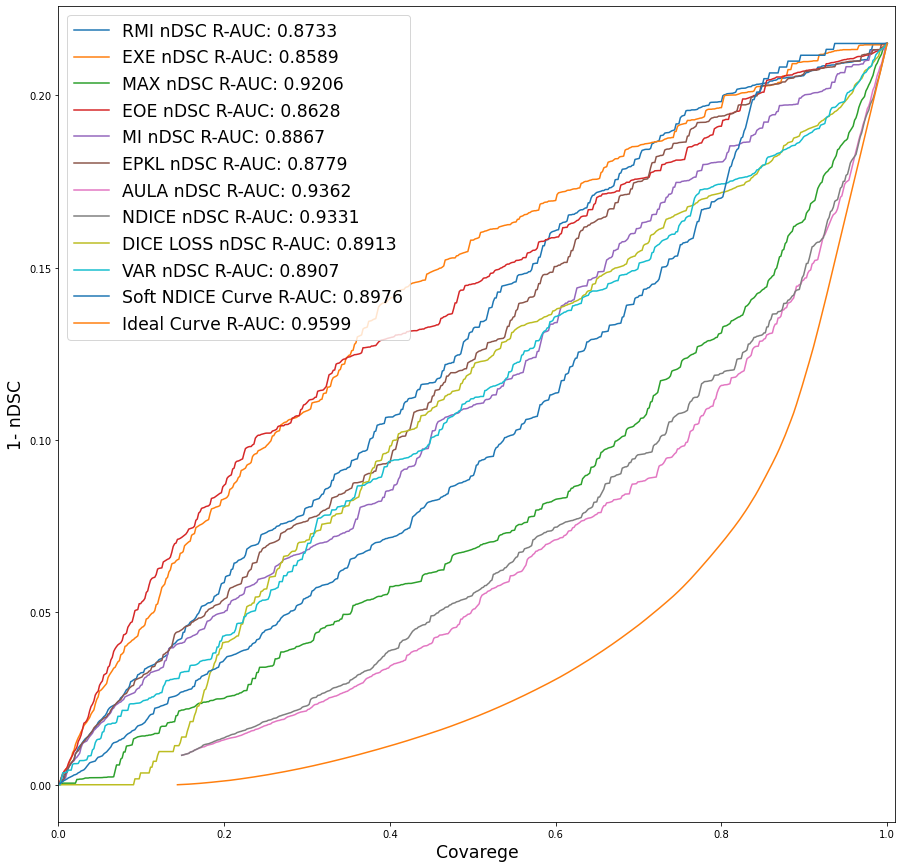

In [72]:
aula_ndsc_test = aula_ndsc_head_func(tests_pred)[7]
tests_uncert_aula_head = uncertainties_heads(tests_pred,7)
test_pred_means = average_head_func(tests_pred)
aula_mean_ndsc_test = aula_ndsc_heads_mean_func(tests_pred,test_pred_means[heads])[7]

norm_dices_test = list()
for ind, p in enumerate(test_pred_means[heads]):
    norm_dices_test.append(dice_norm_metric(p, tests[ind].cpu().numpy().reshape(128,128)))
norm_dices_test = np.asarray(norm_dices_test)

rmi = np.mean(-1*ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['reverse_mutual_information'], axis=(1,2))
exe = np.mean(ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['expected_entropy'], axis=(1,2))
confidences = np.mean(ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['confidence'], axis=(1,2))
eoe = np.mean(ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['entropy_of_expected'], axis=(1,2))
mi = np.mean(-1*ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['mutual_information'], axis=(1,2))
epkl = np.mean(-1*ensemble_uncertainties_classification(tests_uncert_aula_head[:,:,:,:,:])['epkl'], axis=(1,2))
aula_dice_loss_mean = aula_dice_loss_mean_func(tests_pred,test_pred_means[heads])[7]
var_uncert = compute_var_func(tests_pred,test_pred_means)[7]
aula_mean_nsoft_dice_test = aula_nsoft_dice_mean_func(tests_pred,test_pred_means[heads])[7]

x1, y1, tr1 = rc_curve(rmi, norm_dices_test)

x2, y2, tr2 = rc_curve(exe, norm_dices_test)

x3, y3, tr3 = rc_curve(confidences, norm_dices_test)

x4, y4, tr4 = rc_curve(eoe, norm_dices_test)

x5, y5, tr5 = rc_curve(mi, norm_dices_test)

x6, y6, tr6 = rc_curve(epkl, norm_dices_test)

x7, y7, tr7 = rc_curve(aula_ndsc_test, norm_dices_test)

x8, y8, tr8 = rc_curve(aula_mean_ndsc_test, norm_dices_test)

x9, y9, tr9 = rc_curve(aula_dice_loss_mean, norm_dices_test)

x10, y10, tr10 = rc_curve(var_uncert, norm_dices_test)

x11, y11, tr11 = rc_curve(aula_mean_nsoft_dice_test, norm_dices_test)

x12, y12, tr12 = rc_curve(norm_dices_test, norm_dices_test)

plt.figure(figsize=(15,15))
plt.plot(x1, y1, label=f"RMI nDSC R-AUC: {1. - metrics.auc(x1, y1):.4f}")
plt.plot(x2, y2, label=f"EXE nDSC R-AUC: {1. - metrics.auc(x2, y2):.4f}")
plt.plot(x3, y3, label=f"MAX nDSC R-AUC: {1. - metrics.auc(x3, y3):.4f}")
plt.plot(x4, y4, label=f"EOE nDSC R-AUC: {1. - metrics.auc(x4, y4):.4f}")
plt.plot(x5, y5, label=f"MI nDSC R-AUC: {1. - metrics.auc(x5, y5):.4f}")
plt.plot(x6, y6, label=f"EPKL nDSC R-AUC: {1. - metrics.auc(x6, y6):.4f}")
plt.plot(x7, y7, label=f"AULA nDSC R-AUC: {1. - metrics.auc(x7, y7):.4f}")
plt.plot(x8, y8, label=f"NDICE nDSC R-AUC: {1. - metrics.auc(x8, y8):.4f}")
plt.plot(x9, y9, label=f"DICE LOSS nDSC R-AUC: {1. - metrics.auc(x9, y9):.4f}")
plt.plot(x10, y10, label=f"VAR nDSC R-AUC: {1. - metrics.auc(x10, y10):.4f}")
plt.plot(x11, y11, label=f"Soft NDICE Curve R-AUC: {1. - metrics.auc(x11, y11):.4f}")
plt.plot(x12, y12, label=f"Ideal Curve R-AUC: {1. - metrics.auc(x12, y12):.4f}")
plt.xlabel("Covarege", fontsize = 'xx-large')
plt.ylabel("1- nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.show()